## Jupyter notebooks for BLaSA analysis and predictions
- Jupyter notebooks are a sequence of cells, whose output is stored
- Cells must be run for their output to be used
- Click on a cell or use <kbd>&#8593;</kbd> <kbd>&#8595;</kbd> keys to select
- To execute a cell type <kbd>ctrl</kbd>+<kbd>enter</kbd>

In [1]:
import os, time, glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas, json
from scipy.optimize import minimize
from scipy.integrate import cumtrapz
from scipy.interpolate import UnivariateSpline

## Location of data files

In [2]:
with open("../run2/input.json", "r") as f:
    input_data = json.load(f)
dump_folder = os.path.join('../run2',input_data['dump_folder'])
print(dump_folder)
energy_data = np.loadtxt(os.path.join(dump_folder,"E_data"))

../run2/sample_data


# Mean field approach for the fcc lattice

### Unit Lattice Vectors: 

$\hat{\bf a}_1=[110]/\sqrt{2},\quad$
$\hat{\bf a}_2=[1\bar{1}0]/\sqrt{2},\quad$ 

$\hat{\bf a}_3=[101]/\sqrt{2},\quad$
$\hat{\bf a}_4=[10\bar{1}]/\sqrt{2},\quad$ 

$\hat{\bf a}_5=[011]/\sqrt{2},\quad$
$\hat{\bf a}_6=[01\bar{1}]/\sqrt{2},\quad$ 

$\hat{\bf a}_{l+6}\equiv-\hat{\bf a}_{l+6}$

$
{\bf G}_{1l}\hat{\bf a}_l\equiv\hat{\bf a}_1,\quad
\Rightarrow
\quad
\hat{\bf a}_1{\bf G}_{1l} = \hat{\bf a}_l,\quad
$
$\delta{\bf b}\equiv {\bf b}-\langle{\bf b}\rangle,\quad$

---

$
V_\parallel\left(x+\langle{\rm b}_\parallel\rangle \right) = D_0\left(1-e^{-\alpha{x}}\right)^2\to 
D_0\alpha^2{x}^2
,\quad
|x|\ll1
$

---

$
\tilde{U}(\delta{\bf b})
=
    \frac{1}{2}
    \sum_{l\neq1,1+m}
    V_1\left({\bf G}_{1l}\cdot\delta{\bf b}+\langle{\bf b}\rangle \right)
    =
    \frac{1}{2}
    \sum_{l\neq1,1+m}
    V_\parallel\left(\hat{\bf a}_l\cdot\delta{\bf b}+\langle{\rm b}_\parallel\rangle\right)
    +
    \kappa D_0\alpha^2
    \left(
    |\delta{\bf b}|^2-|\hat{\bf a}_l\cdot\delta{\bf b}|^2
    \right)
    ,
$

### Bond Vectors in cylindrical coordinates with axis along ${\bf a}_1$ :

$
\delta{\bf b} = [\delta{\rm b}_\parallel,\delta{\rm b}_\perp\cos(\phi),\delta{\rm b}_\perp\sin(\phi)]
$

$
\hat{\bf a}_1 = [1,0,0] \Rightarrow 
,\quad 
\hat{\bf a}_{2-5} = [1/2,\pm\sqrt{3/8},\pm\sqrt{3/8}]
,\quad 
\hat{\bf a}_6 = [0,1,0]
$

$
\hat{\bf a}_1\cdot\delta{\bf b} = \delta{\rm b}_\parallel
,\quad
\hat{\bf a}_7\cdot\delta{\bf b} = - \hat{\bf a}_1\cdot\delta{\bf b}
$

$
\hat{\bf a}_{2-5}\cdot\delta{\bf b} = \delta{\rm b}_\parallel/2 \pm\sqrt{3/4}\delta{\rm b}_\perp\sin(\phi\pm\pi/4)
,\quad\hat{\bf a}_{8-11}\cdot\delta{\bf b} = - \hat{\bf a}_{2-5}\cdot\delta{\bf b}
$

$
\hat{\bf a}_6\cdot\delta{\bf b} = \cos(\phi){\rm b}_\perp
,\quad\hat{\bf a}_1\cdot\delta{\bf b} = - \hat{\bf a}_2\cdot\delta{\bf b}
$

# Potential Parameters

In [3]:
kb = 8.617e-5
D = input_data['potential']['D0']
a0 = input_data['potential']['a0']
AL = input_data['potential']['AL']
print(input_data['potential'])

{'D0': 0.1, 'a0': 1.856, 'AL': 0.75, 'r_min': 0.0, 'r_max': 7.4}


# Morse potential and fit / solve routines

In [4]:
def boltz(fun,T):
    f = np.exp(-(fun - fun.min())/kb/T)
    return f/f.sum()

In [5]:
def morse(r):
    return D*(1.0+np.exp(-2.0*AL*(r-a0))-2.0*np.exp(-AL*(r-a0)))#D*AL*AL*(r-a0)**2#

In [6]:
def dmorse(r):
    return -2.0*AL*D*(np.exp(-2.0*AL*(r-a0))-np.exp(-AL*(r-a0)))#D*AL*AL*(r-a0)**2#

In [7]:
def ddmorse(r):
    return D*AL*AL*(2.0*np.exp(-2.0*AL*(r-a0))-np.exp(-AL*(r-a0))) # 

In [46]:
M = np.r_[[[1,1,1],[1,0,-1],[1,-2,1]]]

M = (M.T@np.diag(1.0/np.linalg.norm(M,axis=1))).T

v = M@np.r_[[-1,1,-1]]/np.sqrt(3.0)
print(v,v[2]/(2.0*np.sqrt(2.)/3.0) )
v = M@np.r_[[1,1,-1]]/np.sqrt(3.0)
print(v,v[1]/np.sqrt(2./3.),v[2]/np.sqrt(2./9.))
v = M@np.r_[[-1,1,1]]/np.sqrt(3.0)
print(v,v[1]/np.sqrt(2./3.),v[2]/np.sqrt(2./9.))


[-0.33333333  0.         -0.94280904] -1.0000000000000002
[ 0.33333333  0.81649658 -0.47140452] 1.0 -1.0000000000000002
[ 0.33333333 -0.81649658 -0.47140452] -1.0 -1.0000000000000002


### Bond Vectors in cylindrical coordinates with axis along ${\bf a}_1$ :

$
\delta{\bf b} = [\delta{\rm b}_\parallel,\delta{\rm b}_\perp\cos(\phi),\delta{\rm b}_\perp\sin(\phi)]
$

$
\hat{\bf a}_1 = [1,0,0] \Rightarrow 
,\quad 
\hat{\bf a}_{2} = [1/3,\sqrt{2/3},-\sqrt{2/3}]
,\quad 
\hat{\bf a}_{3} = [1/3,0,-2\sqrt{2}/3]
,\quad 
\hat{\bf a}_{4} = [1/3,\sqrt{2/3},-\sqrt{2/3}]
$

$
\hat{\bf a}_1\cdot\delta{\bf b} = \delta{\rm b}_\parallel
,\quad
\hat{\bf a}_7\cdot\delta{\bf b} = - \hat{\bf a}_1\cdot\delta{\bf b}
$

$
\hat{\bf a}_{2-5}\cdot\delta{\bf b} = \delta{\rm b}_\parallel/2 \pm\sqrt{3/4}\delta{\rm b}_\perp\sin(\phi\pm\pi/4)
,\quad\hat{\bf a}_{8-11}\cdot\delta{\bf b} = - \hat{\bf a}_{2-5}\cdot\delta{\bf b}
$

$
\hat{\bf a}_6\cdot\delta{\bf b} = \cos(\phi){\rm b}_\perp
,\quad\hat{\bf a}_1\cdot\delta{\bf b} = - \hat{\bf a}_2\cdot\delta{\bf b}
$

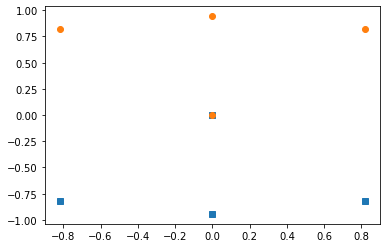

In [49]:
ps = np.zeros((4,2))
ps[1][0] = np.sqrt(2.0/3.0)
ps[1][1] = -np.sqrt(2.0/3.0)
ps[2][0] = -np.sqrt(2.0/3.0)
ps[2][1] = -np.sqrt(2.0/3.0)
ps[3][0] = 0
ps[3][1] = -2.0*np.sqrt(2.0)/3.0


plt.plot(ps[:,0],ps[:,1],'s')
plt.plot(-ps[:,0],-ps[:,1],'o')

In [8]:
"""
Effective potential is seperable into 
longitudinal and transverse components by the observed independence 
of the parallel and perpendicular bond components
"""
def long_potential(r,am=1.0,fsc=0.0,rt=1.0,T=0.1,fcc=True):
    
    # x_0 = x_0, x_1 = x_0 + (r-am)
    aa = am*a0
    dr = r-aa
    dV = fsc*dr + morse(r)
    if fcc:
        """
            110.101 /2  = pm1/2 etc
            101.
        """
        dV += 2.0*morse(aa+dr/2.0)+2.0*morse(aa-dr/2.0) + rt*(4.0*D*AL*AL)*dr**2
    else: # bcc.....
        """
            111.1-11/3 = 1/3 i.e. tetrahedra
        """
        dV += 1.5*morse(aa+dr/3.0)+1.5*morse(aa-dr/3.0) + rt*(4.0*D*AL*AL)*dr**2
        
    V = np.exp(-dV/kb/T)
    V = -np.log(V)*kb*T
    
    return V - V.min()

In [9]:
def tran_potential(r,T=0.1,am=1.0,fsc=0.0,rt=1.0,dint=True,fcc=True):
    
    aa = am*a0
    tc = rt*D*AL*AL
    lc = ddmorse(aa)
    
    if dint:

        theta = np.linspace(-np.pi,np.pi,20,endpoint=True)
        c = np.cos(theta)
        su = np.sin(theta+np.pi/4.0) * np.sqrt(0.75)
        sd = np.sin(theta-np.pi/4.0) * np.sqrt(0.75)
        F = np.zeros(r.size) #

        for i in range(r.size):
            V = morse(su*r[i]+aa)+morse(sd*r[i]+aa)+morse(-su*r[i]+aa)+morse(-sd*r[i]+aa)    
            V += morse(c*r[i]+aa)/2.0+morse(-c*r[i]+aa)/2.0 
            V += tc*(3.5+c*c)*r[i]*r[i]
            II = np.exp(-V/kb/T).sum()
            F[i] += -kb*T*np.log(II.copy())
    else:
        
        F = np.zeros(r.size) #
        if fcc:
            for theta in [0.0,np.pi/4.0,np.pi/2.0,3.0*np.pi/4.0]:
                c = np.cos(theta)
                su = np.sin(theta+np.pi/4.0) * np.sqrt(0.75)
                sd = np.sin(theta-np.pi/4.0) * np.sqrt(0.75)
                V = morse(su*r+aa)+morse(sd*r+aa)+morse(-su*r+aa)+morse(-sd*r+aa)    
                V += morse(c*r+aa)/2.0+morse(-c*r+aa)/2.0 
                F += np.exp(-V/kb/T)
            F = -kb*T*np.log(F) + tc*(3.5+c*c)*r*r
        else:
            for theta in [0.0,np.pi/4.0,np.pi/2.0,3.0*np.pi/4.0]:
                c = np.cos(theta)
                su = np.sin(theta+np.pi/4.0) * np.sqrt(0.75)
                sd = np.sin(theta-np.pi/4.0) * np.sqrt(0.75)
                V = morse(su*r+aa)+morse(sd*r+aa)+morse(-su*r+aa)+morse(-sd*r+aa)    
                V += morse(c*r+aa)/2.0+morse(-c*r+aa)/2.0 
                F += np.exp(-V/kb/T)
            F = -kb*T*np.log(F) + tc*(3.5+c*c)*r*r
    return F-F[0]

In [10]:
"""
Determination of lambda parameter
"""
def find_linear_correction(T=0.1,nstep=10000,minr=0.1,maxr=5.0,am=1.0,rt=1.0):
        
        # base on quad value
        r = np.linspace(minr,maxr,nstep,endpoint=True)
        
        aa = am*a0
        bV = long_potential(r,am=am,fsc=0.0,rt=rt,T=T)
        bV -= bV.min()
        
        sel = bV/T/kb<200.0 
        r,bV = r[sel],bV[sel]
        
        brho = np.exp(-(bV-bV.mean())/T/kb)
        
        def f(m):
            rho = brho * np.exp(-m*(r-aa)/T/kb)
            res = np.abs(np.log( (rho*r).sum() / rho.sum() / aa)).sum()
            return res
        solver = minimize(f, [0.0], method='Nelder-Mead', tol=1e-40)
        
        return solver.x[0]

In [11]:
"""
Determination of effective temperature
'dint' option gives 100x speed up in full_tran_energy with less than 0.1meV/atom error,
leading to 3x speed up in find_T()
"""
def find_T(T=10.0,rt=0.0,am=1.0,nstep=100,dint=True):
    r = np.linspace(0.1,2.5,nstep)*a0
    def dvirialE(_T):
        res = full_tran_energy(T=_T,am=am,rt=rt,dint=dint) * 4.0
        _fsc = find_linear_correction(T=_T,nstep=nstep,am=am,rt=rt,minr=0.1*a0,maxr=2.5*a0)
        _rho = boltz(long_potential(r,am=am,fsc=_fsc,rt=rt,T=_T),_T)
        res += (_rho*dmorse(r)*(r-am*a0)).sum()*2.0
        return np.abs(np.abs(res/kb)/T-1.0)
    kcsolver = minimize(dvirialE, [T], method='Nelder-Mead', tol=1e-30)
    return kcsolver.x[0]

In [12]:
def full_tran_energy(T=0.1,am=1.0,rt=1.0,dint=True):
    r = np.linspace(0.01*a0,2.0*a0,101)
    rho = boltz(tran_potential(r,T=T,am=am,rt=rt,dint=dint)-kb*T*np.log(r),T)
    tc = rt*D*AL*AL
    return tc*(rho*r*r).sum()# / (rho*r).sum()

In [13]:
def calc_approximation(temp_array, a0, RT, am, equ):
    approx_array = np.zeros((temp_array.size,4))   
    approx_array[:,0] = temp_array
    
    r = np.linspace(0.1,3.5,10000)*a0
    
    for ii,T in enumerate(approx_array[:,0]):
        
        sT = T
        tE = full_tran_energy(T=sT,rt=RT,am=am)
        
        # uncorrelated
        lV = long_potential(r,am=am,fsc=0.0,rt=RT,T=sT) +  0.5*morse(2.0*am*a0-r)-0.5*morse(r)
        approx_array[ii][1] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
        # correlated
        fsc = find_linear_correction(T=sT,nstep=1000,am=am,rt=RT,minr=0.1*a0,maxr=4.5*a0)   
        lV = long_potential(r,am=am,fsc=fsc,rt=RT,T=sT)
        approx_array[ii][2] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
        # correlated + virial
        t=time.time()
        sT = find_T(T=T,am=am,rt=RT,dint=False)
        print("find_T(T_vir=",np.round(T),"1+epsilon=",am,"kappa=",RT,") : ",time.time()-t,"seconds")
        
        tE = full_tran_energy(T=sT,rt=RT,am=am)
        fsc = find_linear_correction(T=sT,nstep=1000,am=am,rt=RT,minr=0.1*a0,maxr=4.5*a0)   
        lV = long_potential(r,am=am,fsc=fsc,rt=RT,T=sT)
        approx_array[ii][3] = ((boltz(lV,sT)*(morse(r)-morse(am*a0))).sum() + tE)*6000.0 - equ*T
        
    approx_array = np.r_[approx_array]
    approx_array = approx_array[approx_array[:,0].argsort(),:]
    return approx_array

In [14]:
def analyse_md(df_sub, equ, fT):
    md_array = np.zeros((df_sub.T_vir_md_main.values.size,3))
    md_array[:,0] = df_sub.T_vir_md_main.values
    md_array[:,1] = (df_sub.V_orth_main.values+df_sub.V_para_main.values-md_array[:,0]) * equ # md
    md_array[:,2] = np.sqrt(df_sub.ensemble_error_3.values**2+df_sub.ensemble_error_4.values**2) * equ # mde
    aUs = UnivariateSpline(md_array[:,0],md_array[:,1],s=0.01) # md
    eUs = UnivariateSpline(md_array[:,0],md_array[:,2]+equ*df_sub.ensemble_error_5.values,s=0.01) # mde
    efT = UnivariateSpline(md_array[:,0],df_sub.ensemble_error_5.values,s=0.01)(fT) # T
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    dFeu = -cumtrapz(eUs(fT-efT),1.0/(fT+efT))*(fT[1:]+efT[1:])
    dFel = -cumtrapz(eUs(fT+efT),1.0/(fT-efT))*(fT[1:]-efT[1:])
    return aUs, eUs, dF, dFeu, dFel

# Free energy evaluation

`energy_data` is a `np.array` of all simulation data, where (using slice notation)

- `energy_data[:,0]` = ${\rm T}$, target temperature
- `energy_data[:,1]` = 1+$\epsilon$, dilation
- `energy_data[:,2]` = $\kappa$, transverse strength ratio

- `energy_data[:,3]` = $\langle V_\perp\rangle$, from last half of thermalization stage
- `energy_data[:,4]` = $\langle V_\parallel\rangle$, from last half of thermalization stage
- `energy_data[:,5]` = ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ from last half of thermalization stage
- `energy_data[:,6]` = $\langle V_\perp\rangle$, during main run
- `energy_data[:,7]` = $\langle V_\parallel\rangle$, during main run
- `energy_data[:,8]` = ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ during main run

- `energy_data[:,9+n]` ensemble error in `energy_data[:,3+n]`



We use ${\rm T}^{\rm MD}_{\rm vir}({\rm T})$ from the main run as the temperature for thermodynamic integration

In [15]:
df = pandas.read_csv(os.path.join(dump_folder,"energy_data.csv"))

In [16]:
df

,Unnamed: 0,temperature,dilation,kappa,V_orth_last,V_para_last,T_vir_md_last,V_orth_main,V_para_main,T_vir_md_main,ensemble_error_0,ensemble_error_1,ensemble_error_2,ensemble_error_3,ensemble_error_4,ensemble_error_5
0,0,100.0,1.00,0.0,67.561697,0.000000,68.723927,85.579077,0.000000,87.296308,0.0,0.0,0.0,0.0,0.0,0.0
1,1,200.0,1.00,0.0,134.638916,0.000000,139.377611,169.282164,0.000000,176.092514,0.0,0.0,0.0,0.0,0.0,0.0
2,2,300.0,1.00,0.0,201.271294,0.000000,211.784840,251.294213,0.000000,266.139468,0.0,0.0,0.0,0.0,0.0,0.0
3,3,400.0,1.00,0.0,267.469620,0.000000,285.750225,331.790042,0.000000,357.241062,0.0,0.0,0.0,0.0,0.0,0.0
4,4,500.0,1.00,0.0,333.242091,0.000000,361.103334,410.917189,0.000000,449.242232,0.0,0.0,0.0,0.0,0.0,0.0
5,5,600.0,1.00,0.0,398.597568,0.000000,437.698977,488.800108,0.000000,542.018780,0.0,0.0,0.0,0.0,0.0,0.0
6,6,700.0,1.00,0.0,463.545978,0.000000,515.413649,565.544726,0.000000,635.469900,0.0,0.0,0.0,0.0,0.0,0.0
7,7,800.0,1.00,0.0,528.098110,0.000000,594.141859,641.242092,0.000000,729.512743,0.0,0.0,0.0,0.0,0.0,0.0
8,8,900.0,1.00,0.0,592.265299,0.000000,673.792974,715.971190,0.000000,824.078445,0.0,0.0,0.0,0.0,0.0,0.0
9,9,1000.0,1.00,0.0,656.059142,0.000000,754.288634,789.801103,0.000000,919.109174,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
myc = {}
myc['r'] = (1.0,0.0,44./255.)
myc['b'] = (71./255.,0.0,167./255.)
myc['o'] = (1.0,180./255.,7./255.)
myc['g'] = (0.0/255.0,180./255.,7./255.)
lw=2.
labels = [r"$3{\rm k_BT}/2$","MD"+r"$\pm$"+" error","mean field (mf)","mf+corr. (mfc)","mfc+vir. (mfcv)"]

[ 87.29630835 176.09251437 266.13946819 357.24106195 449.24223153
 542.01878016 635.46990016 729.51274344 824.07844541 919.10917398]


<ipython-input-8-1753ff3c5878>:15: RuntimeWarning: divide by zero encountered in log
  V = -np.log(V)*kb*T


find_T(T_vir= 87.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.4825551509857178 seconds
find_T(T_vir= 176.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.4647960662841797 seconds
find_T(T_vir= 266.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.9797391891479492 seconds
find_T(T_vir= 357.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.45953798294067383 seconds
find_T(T_vir= 449.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.45816707611083984 seconds
find_T(T_vir= 542.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.8442051410675049 seconds
find_T(T_vir= 635.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.48528385162353516 seconds
find_T(T_vir= 730.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.8167757987976074 seconds
find_T(T_vir= 824.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.7997899055480957 seconds
find_T(T_vir= 919.0 1+epsilon= 1.0 kappa= 0.0 ) :  0.4575529098510742 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: -1.809 meV/atom
 	ensemble error in F_md: 0 meV/atom
 	ensemble error in T_vir: 0 K
 

[ 83.87887896 169.79262578 257.37720087 346.3484722  436.48664617
 527.61910109 619.608063

<ipython-input-8-1753ff3c5878>:15: RuntimeWarning: divide by zero encountered in log
  V = -np.log(V)*kb*T


find_T(T_vir= 84.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.4531681537628174 seconds
find_T(T_vir= 170.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.437899112701416 seconds
find_T(T_vir= 257.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.9094676971435547 seconds
find_T(T_vir= 346.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.4688239097595215 seconds
find_T(T_vir= 436.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.4812288284301758 seconds
find_T(T_vir= 528.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.4379599094390869 seconds
find_T(T_vir= 620.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.4487130641937256 seconds
find_T(T_vir= 712.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.9438381195068359 seconds
find_T(T_vir= 806.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.9580800533294678 seconds
find_T(T_vir= 900.0 1+epsilon= 1.04 kappa= 0.0 ) :  0.8334248065948486 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: -2.446 meV/atom
 	ensemble error in F_md: 0 meV/atom
 	ensemble error in T_vir: 0 K
 

[ 94.83868422 190.31231563 286.31614579 382.77381554 479.62417879
 576.81717571 674.

<ipython-input-8-1753ff3c5878>:15: RuntimeWarning: divide by zero encountered in log
  V = -np.log(V)*kb*T


find_T(T_vir= 95.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.45446300506591797 seconds
find_T(T_vir= 190.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.8960740566253662 seconds
find_T(T_vir= 286.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.4959268569946289 seconds
find_T(T_vir= 383.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.467055082321167 seconds
find_T(T_vir= 480.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.4919910430908203 seconds
find_T(T_vir= 577.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.4341578483581543 seconds
find_T(T_vir= 674.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.8382112979888916 seconds
find_T(T_vir= 772.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.9365048408508301 seconds
find_T(T_vir= 870.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.8537299633026123 seconds
find_T(T_vir= 968.0 1+epsilon= 1.0 kappa= 0.2 ) :  0.49215221405029297 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: 0.4219 meV/atom
 	ensemble error in F_md: 0 meV/atom
 	ensemble error in T_vir: 0 K
 

[ 93.53661268 187.87825162 282.89376513 378.4828883  474.56518164
 571.07514692 667.95883345

<ipython-input-8-1753ff3c5878>:15: RuntimeWarning: divide by zero encountered in log
  V = -np.log(V)*kb*T


find_T(T_vir= 94.0 1+epsilon= 1.04 kappa= 0.2 ) :  1.009530782699585 seconds
find_T(T_vir= 188.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.45922303199768066 seconds
find_T(T_vir= 283.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.8407070636749268 seconds
find_T(T_vir= 378.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.8648419380187988 seconds
find_T(T_vir= 475.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.4652848243713379 seconds
find_T(T_vir= 571.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.47776222229003906 seconds
find_T(T_vir= 668.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.4982588291168213 seconds
find_T(T_vir= 765.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.8194348812103271 seconds
find_T(T_vir= 863.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.45079708099365234 seconds
find_T(T_vir= 960.0 1+epsilon= 1.04 kappa= 0.2 ) :  0.49169301986694336 seconds

---- ERROR AT T=1050K---
 	F_mfcv-F_md: 0.2945 meV/atom
 	ensemble error in F_md: 0 meV/atom
 	ensemble error in T_vir: 0 K
 

dEnergy_dFreeEnergy.pdf


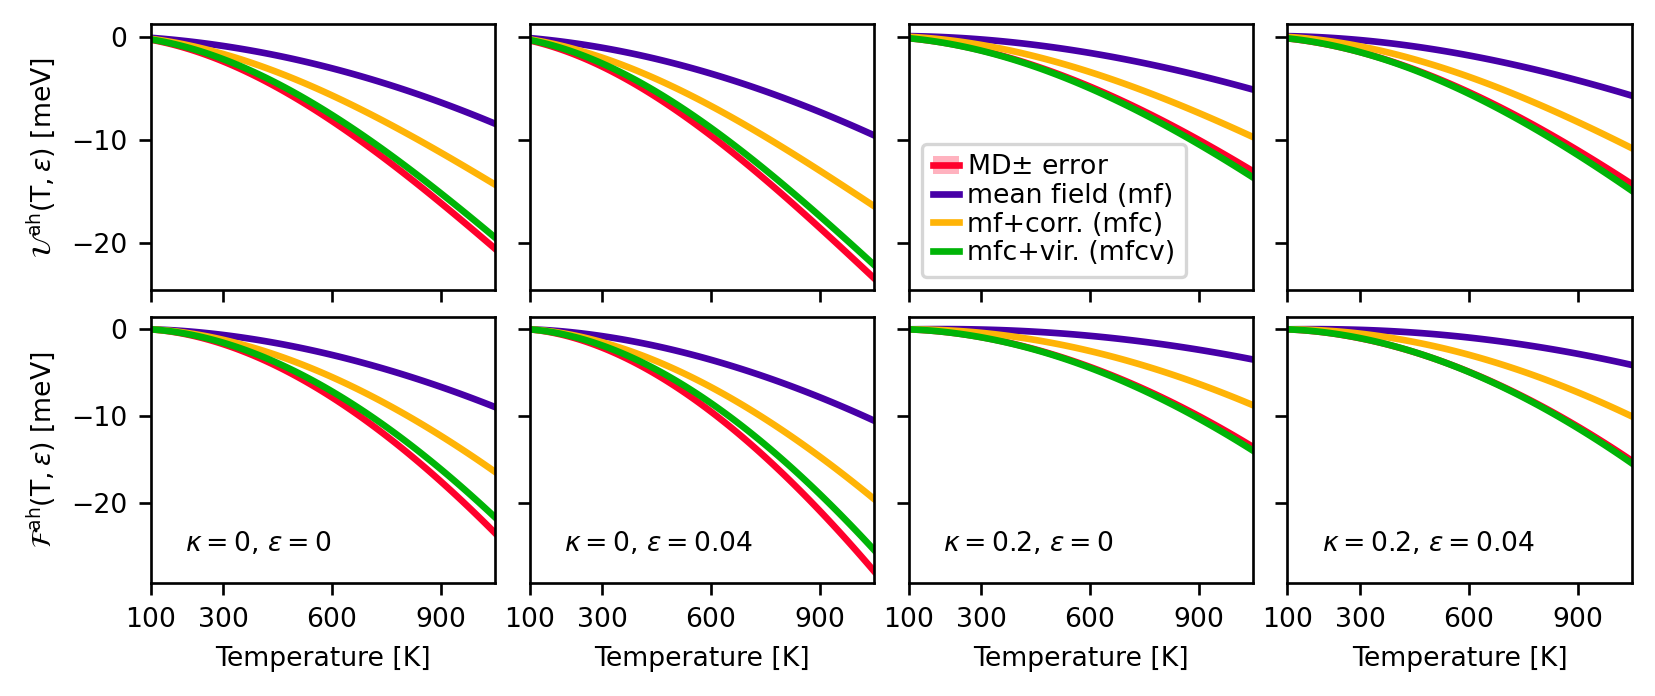

In [18]:
fig,ax=plt.subplots(2,4,figsize=(7,3),dpi=240,sharey="row",sharex="col") #, constrained_layout=True)

for epi in range(4):
    am = [1.0,1.04][epi%2]
    RT=[0.0,0.2][epi//2]
    
    # Filter data 
    df_sub = df[(df.kappa==RT) & (df.dilation==am)]
    df_sub = df_sub.sort_values("temperature")
    df_sub[df_sub.temperature >= 50.0]
    print(df_sub.T_vir_md_main.values)  
    
    equ = 1000.*kb*1.5
    
    # fine grained temperature array for integration
    fT = np.linspace(100.0,1050.0,101)
    
    # Analyse MD data 
    aUs, eUs, dF, dFeu, dFel = analyse_md(
        df_sub=df_sub, 
        equ=equ, 
        fT=fT
    )

    # Plot MD data 
    mde = ax[0,epi].fill_between(fT,y1=aUs(fT)-eUs(fT),y2=aUs(fT)+eUs(fT),facecolor=myc['r'],alpha=0.3,lw=0)
    mdp = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['r'],lw=lw)
    fe = ax[1,epi].fill_between(fT[1:],y1=dF-dFel,y2=dF+dFeu,facecolor=myc['r'],alpha=0.3,lw=0)
    fp = ax[1,epi].plot(fT[1:],dF,'-',c=myc['r'],lw=lw)
    
    rF = -dF[-1]
    
    # Anharmonic approximation 
    approx_array = calc_approximation(
        temp_array=df_sub.T_vir_md_main.values, 
        a0=a0, 
        RT=RT, 
        am=am, 
        equ=equ
    )
    
    # uncorrelated
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,1],s=0.01)
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,1],s=0.01)
    ucmf = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['b'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    ucmff = ax[1,epi].plot(fT[1:],dF,'-',c=myc['b'],lw=lw)
        
    # correlated
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,2],s=0.01) 
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,2],s=0.01)
    cmf = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['o'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    cmff = ax[1,epi].plot(fT[1:],dF,'-',c=myc['o'],lw=lw)
    
    # correlated + virial
    # aUs = UnivariateSpline(Ua[:,0],Ua[:,3],s=0.01)
    aUs = UnivariateSpline(approx_array[:,0],approx_array[:,3],s=0.01)
    cmfv = ax[0,epi].plot(fT,aUs(fT),'-',c=myc['g'],lw=lw)
    dF = -cumtrapz(aUs(fT),1.0/fT)*fT[1:]
    cmffv = ax[1,epi].plot(fT[1:],dF,'-',c=myc['g'],lw=lw)
    rF += dF[-1]
    

    print("\n---- ERROR AT T=%dK---\n" % fT[-1],
          "\tF_mfcv-F_md: %1.4g meV/atom\n" % (-rF),
          "\tensemble error in F_md: %1.4g meV/atom\n" % (np.abs(dFel[-1])/2.0+np.abs(dFeu[-1])/2.0),
          "\tensemble error in T_vir: %1.2g K\n" % (eUs(fT)[-1]),"\n")
    
    ax[1,epi].text(0.1,0.1,r"$\kappa=%.2g$" % RT +", "+r"$\epsilon=%.2g$" % (am-1),\
         fontsize=8,transform=ax[1,epi].transAxes,horizontalalignment='left',verticalalignment='bottom')
    
        
    
"""
Formatting for plot
"""
ax[0,2].legend([(mdp[0],mde),(ucmf[0]),(cmf[0]),(cmfv[0]),],labels[1:5],
        fontsize=8,labelspacing=0.1,handlelength=1.,handletextpad=0.3,loc="lower left")
ax[0,0].set_ylabel(r"$\mathcal{U}^{\rm ah}({\rm T},\epsilon)$ [meV]",fontsize=8)
ax[1,0].set_ylabel(r"$\mathcal{F}^{\rm ah}({\rm T},\epsilon)$ [meV]",fontsize=8)

for i in range(4):
    for j in range(2):    
        ax[j,i].set_xlim(100.0,1050.0)
        ax[j,i].tick_params(axis="x", labelsize=8)
        ax[j,i].tick_params(axis="y", labelsize=8)
        ax[j,i].set_xticks([100.0,300.0,600.0,900.0])
        
    ax[1,i].set_xlabel("Temperature [K]",fontsize=8)
    

plt.tight_layout()

plt.subplots_adjust(hspace=0.1,wspace=0.1)

output_file="dEnergy_dFreeEnergy.pdf"
if not output_file is None:
    print(output_file)
    plt.savefig(output_file,bbox_inches = 'tight',pad_inches = 0)